## Install the dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

# Extract the crops disease dataset zip file

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/BDCropDisease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
print("Extract the dataset zip file successfully.")

Extract the dataset zip file successfully.


# Import the necessaries libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from numpy import expand_dims
from tensorflow.keras import layers, models
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout


# Loading the dataset

In [5]:
BASE_DIRECTORY = r'/content/BDCropDisease/'
train_img_path = r'/content/BDCropDisease/train'
test_img_path = r'/content/BDCropDisease/test'
val_img_path = r'/content/BDCropDisease/val'

# Prepare the dataset

In [6]:
# Get a list of all class labels in the dataset
class_label = os.listdir(train_img_path)
print("Number of class labels found:", len(class_label))

Number of class labels found: 14


In [7]:
class_img_path = []

for class_lbl in class_label:
    # Get a list of all images in the current class
    class_img_name = os.listdir(os.path.join(train_img_path, class_lbl))

    # Add  class label and image path to list
    for img_name in class_img_name:
        img_path = os.path.join(train_img_path, class_lbl, img_name)
        class_img_path.append((class_lbl, img_path))

# Create a DataFrame from the list
df = pd.DataFrame(class_img_path, columns=['Class Label', 'Image Path'])
df

Class Label                                         Image Path
0         Rice___Brown_Spot  /content/BDCropDisease/train/Rice___Brown_Spot...
1         Rice___Brown_Spot  /content/BDCropDisease/train/Rice___Brown_Spot...
2         Rice___Brown_Spot  /content/BDCropDisease/train/Rice___Brown_Spot...
3         Rice___Brown_Spot  /content/BDCropDisease/train/Rice___Brown_Spot...
4         Rice___Brown_Spot  /content/BDCropDisease/train/Rice___Brown_Spot...
...                     ...                                                ...
9107  Corn___Gray_Leaf_Spot  /content/BDCropDisease/train/Corn___Gray_Leaf_...
9108  Corn___Gray_Leaf_Spot  /content/BDCropDisease/train/Corn___Gray_Leaf_...
9109  Corn___Gray_Leaf_Spot  /content/BDCropDisease/train/Corn___Gray_Leaf_...
9110  Corn___Gray_Leaf_Spot  /content/BDCropDisease/train/Corn___Gray_Leaf_...
9111  Corn___Gray_Leaf_Spot  /content/BDCropDisease/train/Corn___Gray_Leaf_...

[9112 rows x 2 columns]

In [8]:
# Let's check how many img for each class are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Class Label'].value_counts()
print(label_count)

Total number of images in the dataset:  9112
Class Label
Rice___Healthy                 1041
Corn___Common_Rust              834
Corn___Healthy                  813
Wheat___Healthy                 781
Potato___Late_Blight            700
Potato___Early_Blight           700
Rice___Neck_Blast               700
Corn___Northern_Leaf_Blight     689
Rice___Leaf_Blast               683
Wheat___Yellow_Rust             646
Wheat___Brown_Rust              631
Rice___Brown_Spot               429
Corn___Gray_Leaf_Spot           359
Potato___Healthy                106
Name: count, dtype: int64


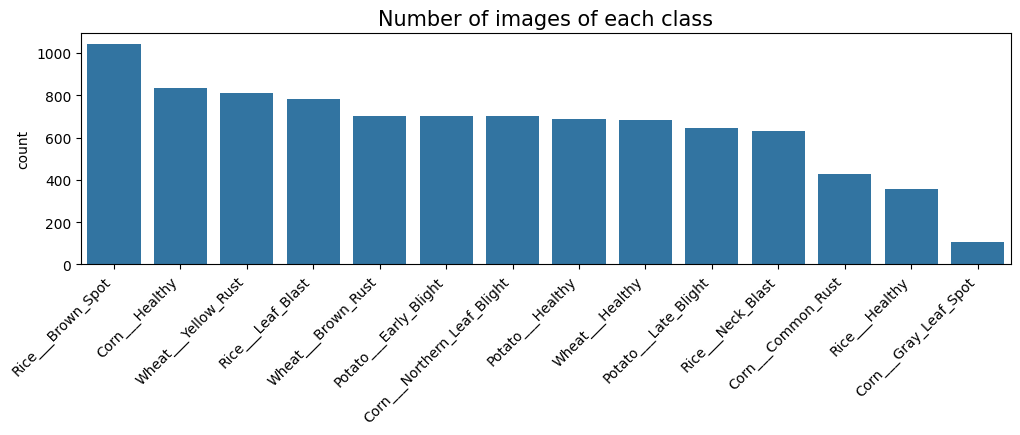

In [9]:
# visualize the class label and number of images
plt.figure(figsize=(12,3))
sns.barplot(  x = class_label, y = label_count)
plt.title("Number of images of each class", fontsize = 15)
plt.xticks(rotation=45, ha='right')
plt.show()

Rice___Brown_Spot


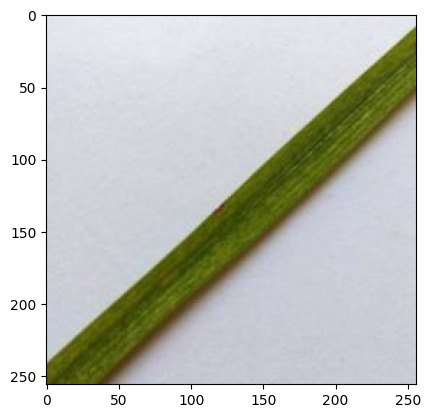

Corn___Healthy


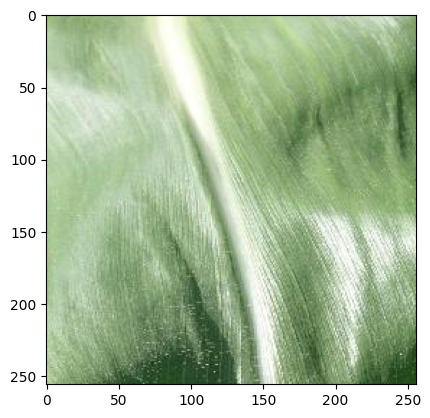

Wheat___Yellow_Rust


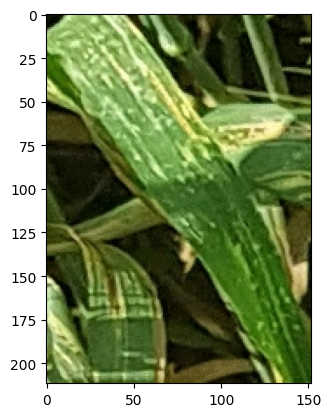

Rice___Leaf_Blast


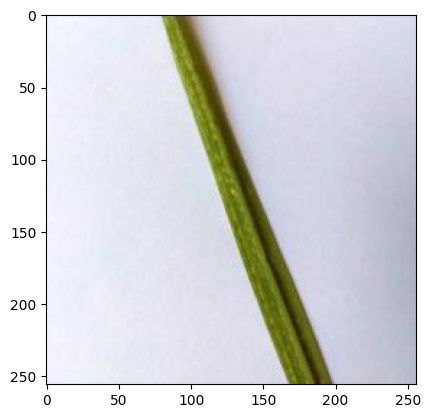

Wheat___Brown_Rust


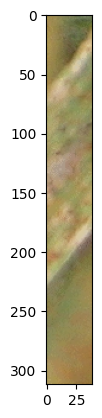

Potato___Early_Blight


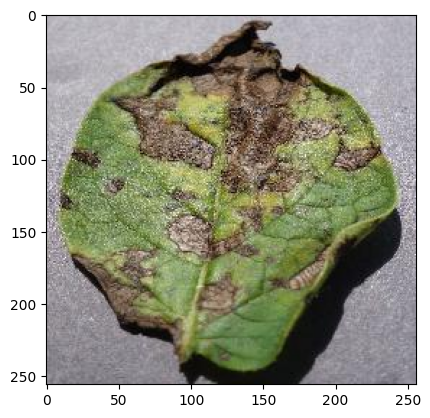

Corn___Northern_Leaf_Blight


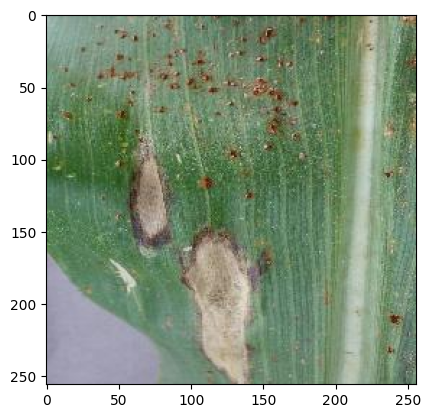

Potato___Healthy


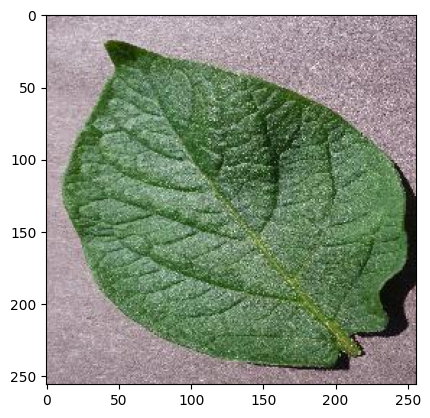

Wheat___Healthy


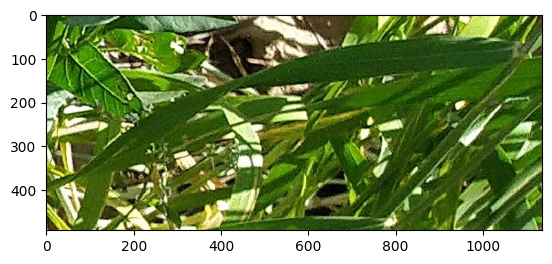

Potato___Late_Blight


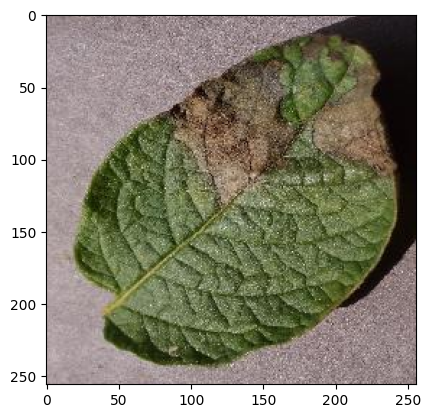

Rice___Neck_Blast


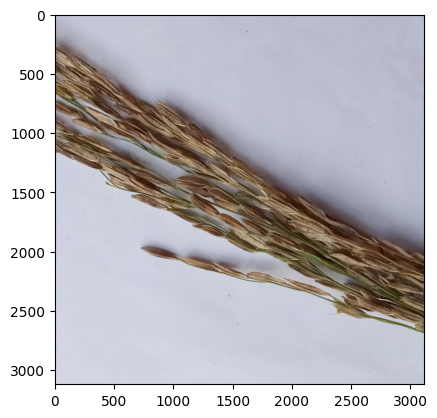

Corn___Common_Rust


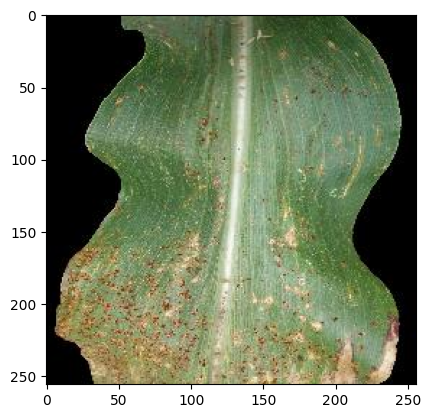

Rice___Healthy


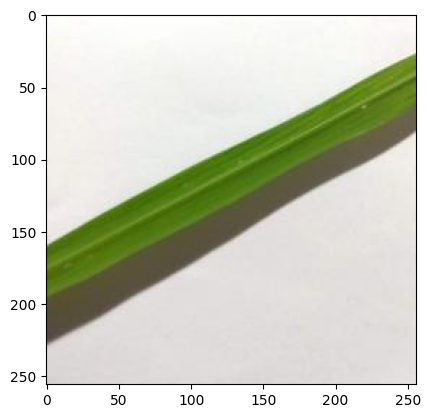

Corn___Gray_Leaf_Spot


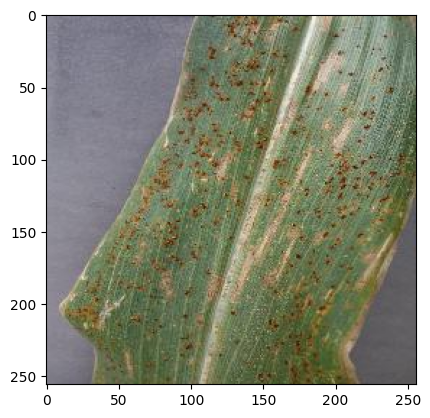

In [10]:
# covert the image to pixel
for folder in os.listdir(train_img_path):
    sub_path = train_img_path + "/" + folder

    print(folder)
    for i in range(1):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        imgplot = plt.imshow(img)
        plt.show()

# Data Preprocessing





In [11]:
# re-size all the images to this
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [12]:
# Data augmentation for training data

train_img_datagenerator = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_img_datagenerator = ImageDataGenerator(rescale = 1./255)

training_set = train_img_datagenerator.flow_from_directory(train_img_path,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

test_set = test_img_datagenerator.flow_from_directory(test_img_path,
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

valid_set = test_img_datagenerator.flow_from_directory(
        val_img_path,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical')

Found 9112 images belonging to 14 classes.
Found 1312 images belonging to 14 classes.
Found 2600 images belonging to 14 classes.


In [13]:
class_indices = training_set.class_indices

# Sort the class indices by their values
sorted_class_indices = sorted(class_indices.items(), key=lambda pair: pair[1])

# Extract the class names from the sorted class indices
class_names = np.array([key.title() for key, value in sorted_class_indices])

# Display the class names
print(class_names)

['Corn___Common_Rust' 'Corn___Gray_Leaf_Spot' 'Corn___Healthy'
 'Corn___Northern_Leaf_Blight' 'Potato___Early_Blight' 'Potato___Healthy'
 'Potato___Late_Blight' 'Rice___Brown_Spot' 'Rice___Healthy'
 'Rice___Leaf_Blast' 'Rice___Neck_Blast' 'Wheat___Brown_Rust'
 'Wheat___Healthy' 'Wheat___Yellow_Rust']


## Build the Model

In [14]:
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout


In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [16]:
VGG16_base_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)


58889256/58889256 [==============================] - 4s 0us/step


In [17]:
#mobilenet_v2_model.summary()

In [18]:
for lay in VGG16_base_model.layers:
    lay.trainable = False

# Add layers
x = Flatten()(VGG16_base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(14, activation='softmax')(x)

# Create the model
model_vgg16 = Model(inputs=VGG16_base_model.input, outputs=output)

# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [19]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-7)
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5)


In [20]:
# Train the model
model_history = model_vgg16.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=30,
    validation_data=valid_set,
    validation_steps=len(valid_set),
    callbacks=[early_stop]

)

Epoch 1/30
285/285 [==============================] - 245s 807ms/step - loss: 0.6332 - accuracy: 0.7682 - val_loss: 0.4370 - val_accuracy: 0.8308
Epoch 2/30
285/285 [==============================] - 230s 806ms/step - loss: 0.3804 - accuracy: 0.8459 - val_loss: 0.3842 - val_accuracy: 0.8569
Epoch 3/30
285/285 [==============================] - 228s 800ms/step - loss: 0.3182 - accuracy: 0.8705 - val_loss: 0.3402 - val_accuracy: 0.8635
Epoch 4/30
285/285 [==============================] - 213s 747ms/step - loss: 0.3032 - accuracy: 0.8764 - val_loss: 0.3305 - val_accuracy: 0.8727
Epoch 5/30
285/285 [==============================] - 232s 814ms/step - loss: 0.2698 - accuracy: 0.8887 - val_loss: 0.3812 - val_accuracy: 0.8581
Epoch 6/30
285/285 [==============================] - 232s 814ms/step - loss: 0.2424 - accuracy: 0.9030 - val_loss: 0.3191 - val_accuracy: 0.8731
Epoch 7/30
285/285 [==============================] - 217s 762ms/step - loss: 0.2320 - accuracy: 0.9073 - val_loss: 0.3285 -

### Training Accuracy vs Validation Graph

In [21]:
accuracy = model_history.history['accuracy']
val_accuracy  = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

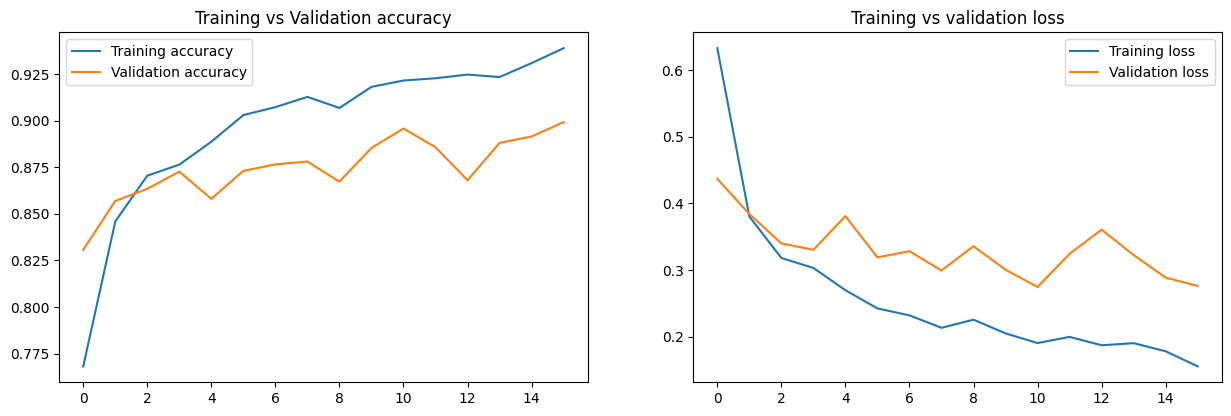

In [22]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

### Evaluate the Model

In [23]:
test_loss, test_acc = model_vgg16.evaluate(test_set, steps=len(test_set))
print('\nTest accuracy:', test_acc)

41/41 [==============================] - 14s 346ms/step - loss: 0.2847 - accuracy: 0.8925

Test accuracy: 0.8925305008888245


In [24]:

model_vgg16.save(r"/content/drive/MyDrive/Upwork/model_vgg16.h5")
## Saving the model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Confusion Matrix and Classification Report


41/41 [==============================] - 13s 326ms/step
Confusion Matrix


<Axes: >

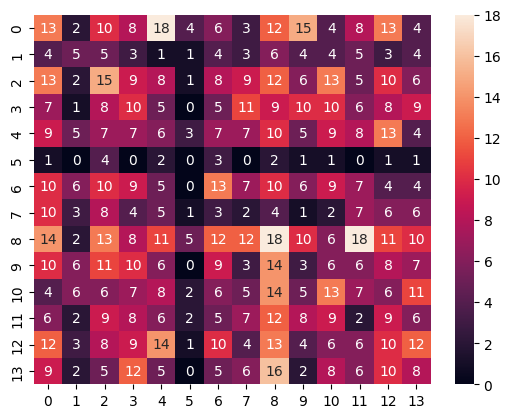

In [25]:
pred_y = model_vgg16.predict(test_set)
y_pred = np.argmax(pred_y, axis=1)
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
sns.heatmap(cm,annot=True)

In [26]:
print('Classification Report')
target_names = class_names
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
                             precision    recall  f1-score   support

         Corn___Common_Rust       0.11      0.11      0.11       120
      Corn___Gray_Leaf_Spot       0.11      0.10      0.10        52
             Corn___Healthy       0.13      0.13      0.13       117
Corn___Northern_Leaf_Blight       0.10      0.10      0.10        99
      Potato___Early_Blight       0.06      0.06      0.06       100
           Potato___Healthy       0.00      0.00      0.00        16
       Potato___Late_Blight       0.14      0.13      0.13       100
          Rice___Brown_Spot       0.03      0.03      0.03        62
             Rice___Healthy       0.12      0.12      0.12       150
          Rice___Leaf_Blast       0.04      0.03      0.03        99
          Rice___Neck_Blast       0.13      0.13      0.13       100
         Wheat___Brown_Rust       0.02      0.02      0.02        91
            Wheat___Healthy       0.09      0.09      0.09       112
        Whe

### Make Prediction On Different Test Image

In [29]:
# Load the test image
test_img_path = r"/content/BDCropDisease/test/Rice___Neck_Blast/IMG20201108163604_00.jpg"


In [30]:
# Preprocess the test image
test_img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(224, 224))
test_img_array = tf.keras.preprocessing.image.img_to_array(test_img)
test_img_array = np.expand_dims(test_img_array, axis=0)
test_img_array = test_img_array / 255.0

In [31]:
# Make predictions
pred = model_vgg16.predict(test_img_array, verbose=0)
pred_index = np.argmax(pred)
predict_class_label = class_names[pred_index]

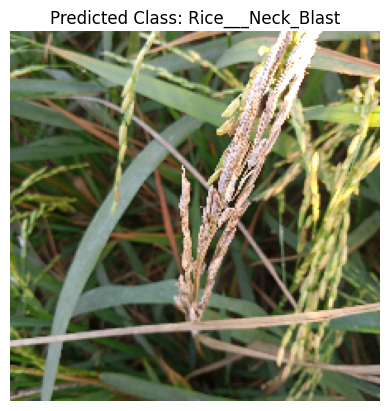

In [32]:
# Display the test image and predicted class label
plt.imshow(test_img)
plt.title(f"Predicted Class: {predict_class_label}")
plt.axis('off')
plt.show()